In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [3]:
df = pd.read_csv('./Amazon.csv')

In [4]:
df['Date'] =  pd.to_datetime(df['Date'])
df.set_index('Date', inplace = True)
df = df[['Close']]
MMS = MinMaxScaler()
df[['Close']] = MMS.fit_transform(df)

In [5]:
valid, test, train = np.split(df, [int(.2* len(df)), int (.4 * len(df))])

/home/itsakphyo/Desktop/AmazonStock/Amazon/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [6]:
def create_seq(df, n_step):
    sequences = []
    labels = []
    for i in range(len(df)-n_step):
        sequence = df.iloc[i : i + n_step]
        label = df.iloc[i + n_step]
        sequences.append(sequence)
        labels.append(label)
    
    return np.array(sequences), np.array(labels)

In [7]:
n_step = 10


train_X, train_y = create_seq(train, n_step)
valid_X, valid_y = create_seq(valid, n_step)
test_X, test_y = create_seq(test, n_step)

train_X = torch.tensor(train_X).float()
train_y = torch.tensor(train_y).float()
valid_X = torch.tensor(valid_X).float()
valid_y = torch.tensor(valid_y).float()
test_X = torch.tensor(test_X).float()
test_y = torch.tensor(test_y).float()

train_X.shape, train_y.shape, valid_X.shape, valid_y.shape, test_X.shape, test_y.shape

(torch.Size([3683, 10, 1]),
 torch.Size([3683, 1]),
 torch.Size([1221, 10, 1]),
 torch.Size([1221, 1]),
 torch.Size([1221, 10, 1]),
 torch.Size([1221, 1]))

In [8]:
class TimeseriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [9]:
train_dataset = TimeseriesDataset(train_X, train_y)
valid_dataset = TimeseriesDataset(valid_X, valid_y)
test_dataset = TimeseriesDataset(test_X, test_y)

batch_size = 16

load_train = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
load_valid = DataLoader(valid_dataset, batch_size = batch_size, shuffle = True)
load_test = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [10]:
class lstm(nn.Module):
    def __init__(self, input_size, hidden_size, num_hidden_layer):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_hidden_layer = num_hidden_layer
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_hidden_layer, batch_first = True)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        bath_size = x.size(0)
        #h0 = torch.zeros(self.num_hidden_layer, bath_size, self.hidden_size).to(device)
        #a0 = torch.zeros(self.num_hidden_layer, bath_size, self.hidden_size).to(device)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [11]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')

    running_loss = 0.0
    
    for batch_index, batch in enumerate(load_train):
        X_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        out = model(X_batch)
        loss = loss_function(out, y_batch)
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1: .8f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0

In [12]:
def valid_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(load_valid):
        X_batch, y_batch = batch[0].to(device), batch[1].to(device)
    
    with torch.no_grad():
        out = model(X_batch)
        loss = loss_function(out, y_batch)
        running_loss += loss
        
    average_valid_loss = running_loss / len(load_valid)
    
    print('Valid Loss: {0: .8f}'.format(average_valid_loss))    
    print('*********************')

In [13]:
model = lstm(1, 16, 1)
model.to(device)
model

lstm(
  (lstm): LSTM(1, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [14]:
num_epoch = 10
lr = 0.001
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

for epoch in range(num_epoch):
    train_one_epoch()
    valid_one_epoch()

Epoch: 1
Batch 100, Loss:  0.05652102
Batch 200, Loss:  0.00117716
Valid Loss:  0.00000779
*********************
Epoch: 2
Batch 100, Loss:  0.00044847
Batch 200, Loss:  0.00036917
Valid Loss:  0.00000516
*********************
Epoch: 3
Batch 100, Loss:  0.00031725
Batch 200, Loss:  0.00030478
Valid Loss:  0.00000445
*********************
Epoch: 4
Batch 100, Loss:  0.00024009
Batch 200, Loss:  0.00023754
Valid Loss:  0.00000155
*********************
Epoch: 5
Batch 100, Loss:  0.00022310
Batch 200, Loss:  0.00018846
Valid Loss:  0.00000099
*********************
Epoch: 6
Batch 100, Loss:  0.00018827
Batch 200, Loss:  0.00016585
Valid Loss:  0.00000051
*********************
Epoch: 7
Batch 100, Loss:  0.00017120
Batch 200, Loss:  0.00016427
Valid Loss:  0.00000098
*********************
Epoch: 8
Batch 100, Loss:  0.00012793
Batch 200, Loss:  0.00016097
Valid Loss:  0.00000060
*********************
Epoch: 9
Batch 100, Loss:  0.00013525
Batch 200, Loss:  0.00013539
Valid Loss:  0.00000002
*****

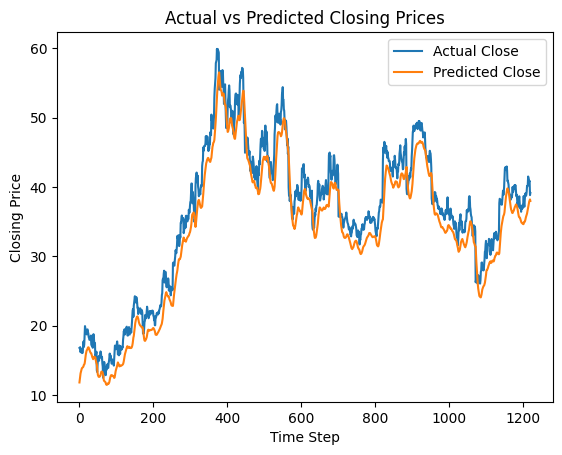

In [15]:
with torch.no_grad():
    predicted = model(test_X.to(device)).to('cpu').numpy()

predicted = MMS.inverse_transform(predicted)
test_y = MMS.inverse_transform(test_y)
plt.plot(test_y, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Time Step')
plt.ylabel('Closing Price')
plt.legend()
plt.title('Actual vs Predicted Closing Prices')
plt.show()